In [28]:
import numpy as np
import matplotlib.pyplot as plt
from Constants import Constants
from astropy.io import ascii
from astropy.table import Table
import seaborn as sns

c=Constants()

%matplotlib inline

plt.rcParams['figure.figsize'] = (5,4)
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.borderpad'] = 0.2
plt.rcParams['legend.labelspacing'] = 0.2
plt.rcParams['legend.handletextpad'] = 0.2
plt.rcParams['font.family'] = 'stixgeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size'] = 16


import importlib.metadata


import pkg_resources

def print_package_version(package_name):
    try:
        version = pkg_resources.get_distribution(package_name).version
        print(f"{package_name} version: {version}")
    except pkg_resources.DistributionNotFound:
        print(f"Package '{package_name}' not found.")
    

print_package_version("numpy")
print_package_version("matplotlib")
print_package_version("astropy")
print_package_version("SEDFit")
print_package_version("isochrones")

Constants defined...
numpy version: 1.24.3
matplotlib version: 3.8.3
astropy version: 5.3.4
SEDFit version: 0.6.3
isochrones version: 2.1


In [2]:
def a_RL(q):
    """Eggelton formula, q=M2/M1 (opposite of eggelton deff)"""
    return (0.6*q**(-2./3.) + np.log(1+q**(-1./3.)))/(0.49*q**(-2./3.))

def omega_pseudo_factor_rp(ecc):
    """omega_pseudo = omega_pseudo_factor * omega_orb(rp) """
    return (1+7.5*ecc**2 + 45/8.*ecc**4 + 5/16.*ecc**6)/((1+3*ecc**2 +3/8.*ecc**4)*(1-ecc**2)**1.5) * (1-ecc)**1.5

def omega_peri_factor_rp(ecc):
    """ omega_peri = omega_peri_factor * omega_orb(rp) """
    return (1+ecc)**0.5 #/(1-ecc)**1.5

def omega_pseudo_factor(ecc):
    """omega_pseudo = omega_pseudo_factor * omega_orb(a) """
    return (1+7.5*ecc**2 + 45/8.*ecc**4 + 5/16.*ecc**6)/((1+3*ecc**2 +3/8.*ecc**4)*(1-ecc**2)**1.5) 

def omega_peri_factor(ecc):
    """ omega_peri = omega_peri_factor * omega_orb(a) """
    return (1+ecc)**0.5 /(1-ecc)**1.5

def Omega_RL(M,R,q=1):
    return np.sqrt(c.G*M/(a_RL(q)*R)**3)



In [3]:
# READ THE TABLE
hb = Table.read("SEDFitting/ogle_hb_sedfit_r2r.csv")
hb['Pcirc'] = hb['P'] * (1-hb['Ecc']**2)**1.5
hb['sed_cs'] = np.sqrt(c.kB* hb['sed_teff']/(0.61*c.mp))
hb['Omega_orb'] = 2*np.pi/(hb['P']*86400)
hb['Omega_peri'] = omega_peri_factor(hb['Ecc'])*hb['Omega_orb']
hb['Omega_pseudo'] = omega_pseudo_factor(hb['Ecc'])*hb['Omega_orb']
hb['AoRcrit_zero']  = (hb['sed_cs']/hb['Omega_peri']) / (hb['sed_radius']*c.rsun)
hb['Omega_tide_pseudo'] = (hb['Omega_peri']-hb['Omega_pseudo'])
hb['AoRcrit_pseudo']  = (hb['sed_cs']/hb['Omega_tide_pseudo']) / (hb['sed_radius']*c.rsun)
hb['sed_L_err'] = hb['sed_L']*np.sqrt(2*(hb['sed_radius_err']/hb['sed_radius'])**2 + 4*(hb['sed_teff_err']/hb['sed_teff'])**2)

def p_cut(rstar):
    return 2*np.pi*np.sqrt( (2*a_RL(2)*rstar*c.rsun)**3/(c.G*0.5*c.msun) )/86400.


hb['tidal_flag'] = hb['Pcirc']<p_cut(hb['sed_radius'])

# supply adjusted amplitude estimates for a few stars
hb['A_adjust'] = np.nan
A_adjust_dict = {'OGLE-LMC-HB-0020':0.35,
                 'OGLE-LMC-HB-0032':0.05,
                 'OGLE-LMC-HB-0341':0.01,
                 'OGLE-LMC-HB-0347':0.02,
                 'OGLE-LMC-HB-0408':0.15,
                 'OGLE-SMC-HB-0007':0.3}
for i in range(len(hb)):
    if hb['ID'][i] in A_adjust_dict:
        hb['A_adjust'][i] = A_adjust_dict[hb['ID'][i]]
# amplitude including adjusted values
hb['A_hb'] = np.where(np.isnan(hb['A_adjust']),hb['A'],hb['A_adjust'])


hb['f_crit_zero'] = hb['A_hb']/hb['AoRcrit_zero']
hb['f_crit_pseudo'] = hb['A_hb']/hb['AoRcrit_pseudo']



print(hb.keys())


['ID', 'Type', 'RA', 'Decl', 'I', 'V', 'V_I', 'P', 'T0', 'A', 'Ecc', 'Incl', 'Peri', 'Model', 'loc', 'sed_dist', 'sed_av', 'sed_av_err', 'sed_radius', 'sed_radius_err', 'sed_teff', 'sed_teff_err', 'sed_logg', 'sed_logg_err', 'sed_feh', 'sed_irslope', 'sed_chi2oN', 'Av_median', 'Av_minus_two_sigma', 'Av_plus_two_sigma', 'sed_L', 'Pcirc', 'sed_cs', 'Omega_orb', 'Omega_peri', 'Omega_pseudo', 'AoRcrit_zero', 'Omega_tide_pseudo', 'AoRcrit_pseudo', 'sed_L_err', 'tidal_flag', 'A_adjust', 'A_hb', 'f_crit_zero', 'f_crit_pseudo']


In [4]:
hb[hb['tidal_flag']==False]

ID,Type,RA,Decl,I,V,V_I,P,T0,A,Ecc,Incl,Peri,Model,loc,sed_dist,sed_av,sed_av_err,sed_radius,sed_radius_err,sed_teff,sed_teff_err,sed_logg,sed_logg_err,sed_feh,sed_irslope,sed_chi2oN,Av_median,Av_minus_two_sigma,Av_plus_two_sigma,sed_L,Pcirc,sed_cs,Omega_orb,Omega_peri,Omega_pseudo,AoRcrit_zero,Omega_tide_pseudo,AoRcrit_pseudo,sed_L_err,tidal_flag,A_adjust,A_hb,f_crit_zero,f_crit_pseudo
str16,str2,str11,str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64
OGLE-LMC-HB-0030,MS,04:55:31.22,-69:28:05.5,16.516,16.656,0.14,395.067,9386.9,0.097,0.4619,35.15,35.4,0,LMC,49970.0,0.4553998476061154,0.1797753583027964,7.611649898724677,0.3200597756512951,12966.731095462303,1070.8660499772868,2.2267582976706337,412999.918635959,-0.7,0.15656137786816718,0.8214266416794171,0.261,0.004500000000000004,0.558,1486.9570074902779,275.63968297404796,1324629.7424298238,1.84075238292316e-07,5.638449775920822e-07,4.5521461909885074e-07,4.437709273770507,1.0863035849323143e-07,23.033893294066708,261.03506733939605,False,nan,0.097,0.021858124094186953,0.004211185610770637
OGLE-LMC-HB-0122,MS,05:10:47.57,-70:10:46.6,14.799,15.025,0.226,259.478,9145.82,0.097,0.4055,65.2,56.8,1,LMC,49970.0,0.34224238487958414,0.2511995534431097,14.676587022806462,1.4598960903193923,13999.999990052387,3121.3324384769653,1.6514778442328752,348004.4059467838,-0.7,0.14636810804251293,1.1974118983933353,0.1845,0.0,0.5129999999999999,7512.441001204984,198.18674511776942,1376395.574675171,2.8026288227298805e-07,7.248584742954352e-07,5.82514047918626e-07,1.8602351173876408,1.4234442637680918e-07,9.47284852201335,3512.577844211497,False,nan,0.097,0.05214394626428659,0.010239792156982968
OGLE-LMC-HB-0167,MS,05:16:25.41,-69:28:55.2,15.065,15.312,0.247,242.67,9056.6,0.038,0.152,21.32,22.3,0,LMC,49970.0,0.14320275769057927,0.16037652831559832,12.32476268006444,1.047966650975027,14000.000031737847,2254.287631803496,1.485873957621103,365745.9506304074,-0.7,0.13355244993307333,1.5113316453456158,0.11925,0.0,0.46575,5297.708552231497,234.3087931650444,1376395.5767243025,2.996746699898232e-07,4.118911843410764e-07,3.413539250370615e-07,3.898388090265726,7.05372593040149e-08,22.764021502452987,1821.136508408086,False,nan,0.038,0.009747618533641119,0.0016693008305191253
OGLE-LMC-HB-0281,MS,05:29:13.46,-67:00:08.7,15.482,15.551,0.069,158.022,9139.24,0.203,0.209,89.7,76.39,0,LMC,49970.0,0.3705071756053009,0.09247435863196941,9.186212937003665,0.7528820797676326,19000.000056666435,2070.6335847954647,0.14216493765214197,233148.00167883627,-0.7,0.17509697442097882,1.422131957782488,0.1845,0.0,0.459,9984.037651656849,147.78206496017842,1603452.3226608569,4.602020741822683e-07,7.192783641325012e-07,5.819230905594134e-07,3.489196367165028,1.373552735730878e-07,18.27162066534049,2464.689805440323,False,nan,0.203,0.05817958596722302,0.011110125572225321
OGLE-LMC-HB-0289,MS,05:29:51.27,-71:57:10.1,16.346,16.544,0.198,2555.5,10621.9,0.182,0.4564,50.77,38.4,0,LMC,49970.0,0.15720684658145803,0.1620327345104253,6.45269869880364,0.5279879206252724,14000.000115182464,2202.5027364058383,1.7014441394612818,296052.934192643,-0.7,0.10863400409443846,1.4984416861837104,0.26775,0.05624999999999999,0.46125,1452.1574767091074,1800.1805404946467,1376395.5808261882,2.8457073827599452e-08,8.568630267550892e-08,6.914644154544808e-08,35.79260806894236,1.6539861130060837e-08,185.4269648592858,486.83202591352773,False,nan,0.182,0.005084848794741041,0.00098151851937022
OGLE-SMC-HB-0025,MS,00:56:25.81,-72:22:15.1,16.113,16.104,-0.009,186.397,9077.2,0.053,0.2566,43.8,179.9,0,SMC,62440.0,0.47192980409948737,0.1546927026268401,10.35577182989216,0.3870476310443488,15249.66177477644,1438.022672820739,1.727270094201907,274376.630877522,-1.05,0.11144879531467934,6.

median errors:
dT/T (all, cool hot): 0.05939512300722251 0.055678960032977926 0.12537666197994948
dR/R (all, cool hot): 0.030891709008064778 0.030050304104390343 0.06504083625153737
Av   (all, cool hot): 0.9468135963782112 0.9338406091916971 1.1199262563234063
logg   (all, cool hot): 0.5570504363154956 0.5174993012943203 198684.33881645044
L    (all, cool hot): 0.12735721712586232 0.11868000698369613 0.26593261918344824


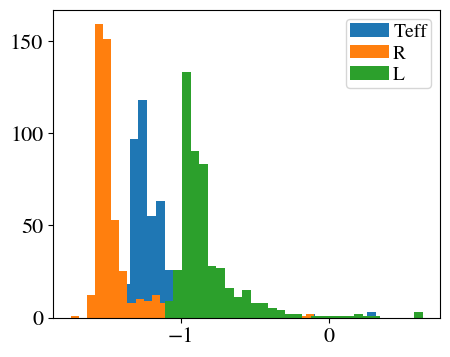

In [5]:
## Errors

plt.hist( np.log10( hb['sed_teff_err'] / hb['sed_teff']) ,bins=30 ,label='Teff')
plt.hist( np.log10( hb['sed_radius_err']/hb['sed_radius']) ,bins=30,label='R')
plt.hist( np.log10(hb['sed_L_err']/hb['sed_L']),bins=30,label='L')
#plt.hist( np.log10( hb['sed_av_err'] / hb['sed_av']) ,bins=30 ,label='Av')
plt.legend()

selc = hb['sed_teff']<6000
print("median errors:")
print("dT/T (all, cool hot):",np.median((hb['sed_teff_err'] / hb['sed_teff'])),
                              np.median((hb['sed_teff_err'] / hb['sed_teff'])[selc]),
                              np.median((hb['sed_teff_err'] / hb['sed_teff'])[selc==False]) )
print("dR/R (all, cool hot):",np.median((hb['sed_radius_err'] / hb['sed_radius'])),
                              np.median((hb['sed_radius_err'] / hb['sed_radius'])[selc]),
                              np.median((hb['sed_radius_err'] / hb['sed_radius'])[selc==False]) )
print("Av   (all, cool hot):",np.median((hb['sed_av_err']/hb['sed_av'] )),
                              np.median((hb['sed_av_err']/hb['sed_av'] )[selc]),
                              np.median((hb['sed_av_err']/hb['sed_av'])[selc==False]) )
print("logg   (all, cool hot):",np.median((hb['sed_logg_err']/hb['sed_logg'] )),
                              np.median((hb['sed_logg_err']/hb['sed_logg'] )[selc]),
                              np.median((hb['sed_logg_err']/hb['sed_logg'])[selc==False]) )
print("L    (all, cool hot):",np.median((hb['sed_L_err']/hb['sed_L'] )),
                              np.median((hb['sed_L_err']/hb['sed_L'] )[selc]),
                              np.median((hb['sed_L_err']/hb['sed_L'])[selc==False]) )

In [6]:
error_sel = hb['sed_teff_err'] / hb['sed_teff']>0.3
#len(hb[hb[error_sel])
hb[error_sel]



ID,Type,RA,Decl,I,V,V_I,P,T0,A,Ecc,Incl,Peri,Model,loc,sed_dist,sed_av,sed_av_err,sed_radius,sed_radius_err,sed_teff,sed_teff_err,sed_logg,sed_logg_err,sed_feh,sed_irslope,sed_chi2oN,Av_median,Av_minus_two_sigma,Av_plus_two_sigma,sed_L,Pcirc,sed_cs,Omega_orb,Omega_peri,Omega_pseudo,AoRcrit_zero,Omega_tide_pseudo,AoRcrit_pseudo,sed_L_err,tidal_flag,A_adjust,A_hb,f_crit_zero,f_crit_pseudo
str16,str2,str11,str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64
OGLE-LMC-HB-0071,MS,05:03:10.35,-68:38:36.2,14.648,14.486,-0.162,6.214827,9002.333,0.023,0.163,33.8,7.8,1,LMC,49970.0,1.1499845529961222e-14,1.9525483641240307,12.438714356201407,9.55014571255531,19437.370447408255,39406.7637204507,2.999999999999952,14.84254182214436,-0.7,0.06757139125476494,1.3693649416318854,0.19799999999999998,0.0,0.39599999999999996,20050.251350854338,5.968796920607025,1621802.65039144,1.1701379968650841e-05,1.6479299712326828e-05,1.3574401393445541e-05,0.11375922489918562,2.904898318881287e-06,0.645348702903182,84163.05180088429,True,nan,0.023,0.20218140568716772,0.03563964705674873
OGLE-LMC-HB-0110,MS,05:08:18.59,-70:37:40.0,16.807,17.088,0.281,7.49809,9006.044,0.031,0.327,45.7,179.3,0,LMC,49970.0,0.01800000000000018,2.782484018514905,8.566176879990701,3.241413354334734,8206.655997497852,8209.745216416806,2.9999999999999996,5.784268061940016,-0.7,0.04884872388302825,2.2071424542683906,0.30600000000000005,0.018000000000000016,0.6165,302.1744757891117,6.328191741280661,1053810.1192255127,9.698743568886262e-06,2.0236171063531085e-05,1.6188718370057916e-05,0.08740773178170952,4.047452693473169e-06,0.4370150676405039,625.8280826794979,True,nan,0.031,0.3546597007850385,0.07093576925704798
OGLE-LMC-HB-0194,MS,05:18:39.70,-69:32:35.6,15.515,15.412,-0.103,11.95267,9005.88,0.025,0.511,31.7,5.0,0,LMC,49970.0,3.8157122439294614e-12,0.8559785689683141,7.621278073908201,2.392023755884661,19815.777082546523,16793.340770028124,2.9999999999998885,20.62804402558761,-0.7,-0.07081236018354242,2.447755337167801,0.22725,0.0,0.61875,8130.529548186223,7.591453120489803,1637513.17896482,6.0841679864357e-06,2.187107551466514e-05,1.7727214203206772e-05,0.14125041150597625,4.143861311458368e-06,0.7455120199081907,14245.516826746565,True,nan,0.025,0.1769906348127153,0.03353399989859149
OGLE-LMC-HB-0256,MS,05:26:28.44,-66:37:54.0,15.586,15.469,-0.117,6.58432,9005.05,0.022,0.23,41.2,141.0,0,LMC,49970.0,0.002250000009374124,0.7273232375110676,9.230704627848755,2.4838792810797155,15503.996460646955,11416.727527346748,2.9999999999999996,4.7088546401259315,-0.7,0.0010705767237245984,1.536322263361311,0.20925,0.002250000000000002,0.43875000000000003,4469.543161929075,6.068825979309252,1448441.9026165374,1.1044732359063714e-05,1.812890880339842e-05,1.4594768600115515e-05,0.12445072396467934,3.5341402032829065e-06,0.6383888854145658,6798.701930493176,True,nan,0.022,0.17677679405259122,0.03446175286355954
OGLE-LMC-HB-0330,MS,05:34:10.74,-67:26:45.4,14.499,14.361,-0.138,9.46739,9003.06,0.019,0.364,57.0,32.0,0,LMC,49970.0,0.2675183171064489,0.3027547196594316,10.922450055634824,2.3455824149694937,25999.99971781901,9954.438174880392,0.5715675326842584,150388.72186265225,-0.7,-0.015622822374037695,2.8327502690283985,0.32849999999999996,0.0,0.8415,49493.970242157404,7.649578342559322,1875710.983829806,7.681320001228469e-06,1.7687130075481783e-05,1.4172587585130968e-05,0.1396019067041012,3.5145424903508154e-06,0.7025543408394653,40770.84793387696,True,nan,0.019,0.13610129294488943,0.027044171383664578
OGLE-LMC-HB-0342,MS,05:35:23.56,-68:49:01.9,15.527,15.425,-0.102,6.661426,9005.877,0.027,0.22,35.6,4.0,1,LMC,49970.0,0.03150000000608407,1.9498279667372551,9.342211909781458,6.140217415165418,17707.364785085952,33919.853443470456,2.

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


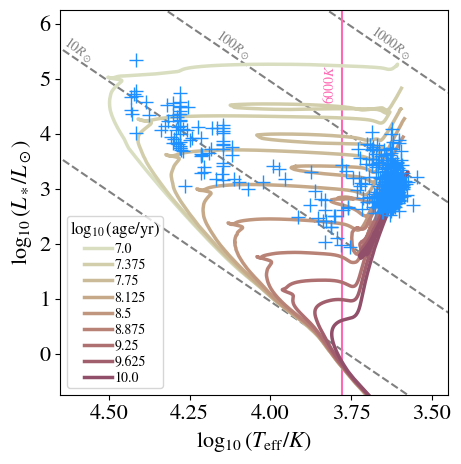

In [7]:
from isochrones.mist import MIST_BasicIsochrone

mist = MIST_BasicIsochrone()
feh = -1
plt.figure(figsize=(5,5))

agelist = np.linspace(7,10,9)
pal = sns.cubehelix_palette(len(agelist), start=0,rot=0.6,light=0.85,dark=0.4) 
for i,la in enumerate(agelist):
    iso=mist.isochrone(la,feh)[['logTeff','logL','phase']]
    sel = (iso['phase']>-1) & (iso['phase']<=4)
    plt.plot(iso['logTeff'][sel],iso['logL'][sel],color=pal[i],lw=2.5,alpha=1,label=la,rasterized=True)

plt.legend(title='$\log_{10}$(age/yr)',loc='lower left',fontsize=10, title_fontsize=12)

plt.xlim(4.65,3.45)
plt.ylim(-0.75,6.25)

plt.plot(np.log10(hb['sed_teff']),np.log10(hb['sed_L']),'+' ,alpha=1,color='DodgerBlue',markersize=10,rasterized=True)


plt.xlabel(r"$\log_{10}\left(T_{\rm eff}/K\right)$")
plt.ylabel(r"$\log_{10}\left(L_\ast/L_\odot\right)$")

xp = np.linspace(5,3,100)
for rr in np.logspace(0,3,4):
    plt.plot(xp,np.log10(4*np.pi*(rr*c.rsun)**2 * c.sigmaSB * (10**xp)**4 /3.84e33),zorder=0,ls='--',color='grey' )

plt.annotate("$10 R_\odot$",(4.65,5.3),fontsize=10,rotation=-35,color='grey')
plt.annotate("$100 R_\odot$",(4.18,5.35),fontsize=10,rotation=-35,color='grey')
plt.annotate("$1000 R_\odot$",(3.7,5.35),fontsize=10,rotation=-35,color='grey')   
    
plt.axvline(np.log10(6000),color='HotPink',zorder=0)
plt.annotate('$6000K$',(3.84,4.6),rotation=90,color='HotPink',fontsize=10)
plt.savefig("figs/HRD.pdf",bbox_inches='tight',dpi=300)

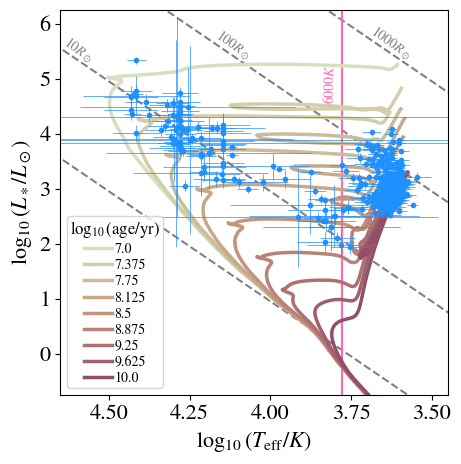

In [8]:
mist = MIST_BasicIsochrone()
feh = -1
plt.figure(figsize=(5,5))

agelist = np.linspace(7,10,9)
pal = sns.cubehelix_palette(len(agelist), start=0,rot=0.6,light=0.85,dark=0.4) 
for i,la in enumerate(agelist):
    iso=mist.isochrone(la,feh)[['logTeff','logL','phase']]
    sel = (iso['phase']>-1) & (iso['phase']<=4)
    plt.plot(iso['logTeff'][sel],iso['logL'][sel],color=pal[i],lw=2.5,alpha=1,label=la,rasterized=True)

plt.legend(title='$\log_{10}$(age/yr)',loc='lower left',fontsize=10, title_fontsize=12)

plt.xlim(4.65,3.45)
plt.ylim(-0.75,6.25)

#plt.plot(np.log10(hb['sed_teff']),np.log10(hb['sed_L']),'+' ,alpha=1,color='DodgerBlue',markersize=10,rasterized=True)
plt.errorbar(x=np.log10(hb['sed_teff']),y=np.log10(hb['sed_L']),
             xerr=np.log10(np.exp(1))*hb['sed_teff_err']/hb['sed_teff'],
             yerr=np.log10(np.exp(1))*hb['sed_L_err']/hb['sed_L'],linestyle='',
              alpha=1,color='DodgerBlue',rasterized=True,
            elinewidth=0.5,marker='o',markersize=3)

plt.xlabel(r"$\log_{10}\left(T_{\rm eff}/K\right)$")
plt.ylabel(r"$\log_{10}\left(L_\ast/L_\odot\right)$")

xp = np.linspace(5,3,100)
for rr in np.logspace(0,3,4):
    plt.plot(xp,np.log10(4*np.pi*(rr*c.rsun)**2 * c.sigmaSB * (10**xp)**4 /3.84e33),zorder=0,ls='--',color='grey' )

plt.annotate("$10 R_\odot$",(4.65,5.3),fontsize=10,rotation=-35,color='grey')
plt.annotate("$100 R_\odot$",(4.18,5.35),fontsize=10,rotation=-35,color='grey')
plt.annotate("$1000 R_\odot$",(3.7,5.35),fontsize=10,rotation=-35,color='grey')   
    
plt.axvline(np.log10(6000),color='HotPink',zorder=0)
plt.annotate('$6000K$',(3.84,4.6),rotation=90,color='HotPink',fontsize=10)
plt.savefig("figs/HRD_err.pdf",bbox_inches='tight',dpi=300)

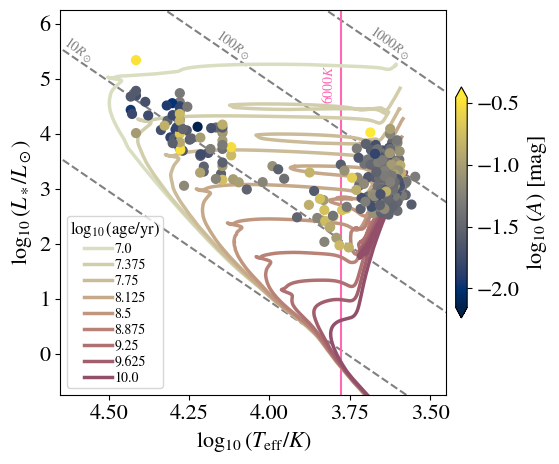

In [9]:

feh = -1
plt.figure(figsize=(6,5))

agelist = np.linspace(7,10,9)
pal = sns.cubehelix_palette(len(agelist), start=0,rot=0.6,light=0.85,dark=0.4) 
for i,la in enumerate(agelist):
    iso=mist.isochrone(la,feh)[['logTeff','logL','phase']]
    sel = (iso['phase']>-1) & (iso['phase']<=4)
    plt.plot(iso['logTeff'][sel],iso['logL'][sel],color=pal[i],lw=2.5,alpha=1,label=la,rasterized=True)

plt.legend(title='$\log_{10}$(age/yr)',loc='lower left',fontsize=10, title_fontsize=12)

plt.xlim(4.65,3.45)
plt.ylim(-0.75,6.25)

#plt.plot(np.log10(hb['sed_teff']),np.log10(hb['sed_L']),'+' ,alpha=1,color='DodgerBlue',markersize=10,rasterized=True)


plt.xlabel(r"$\log_{10}\left(T_{\rm eff}/K\right)$")
plt.ylabel(r"$\log_{10}\left(L_\ast/L_\odot\right)$")

xp = np.linspace(5,3,100)
for rr in np.logspace(0,3,4):
    plt.plot(xp,np.log10(4*np.pi*(rr*c.rsun)**2 * c.sigmaSB * (10**xp)**4 /3.84e33),zorder=0,ls='--',color='grey' )

plt.annotate("$R_*=1 R_\odot$",(4.84,3.9) ,fontsize=10,rotation=-35,color='grey')
plt.annotate("$10 R_\odot$",(4.65,5.3),fontsize=10,rotation=-35,color='grey')
plt.annotate("$100 R_\odot$",(4.18,5.35),fontsize=10,rotation=-35,color='grey')
plt.annotate("$1000 R_\odot$",(3.7,5.35),fontsize=10,rotation=-35,color='grey')   
    
plt.axvline(np.log10(6000),color='HotPink',zorder=0)
plt.annotate('$6000K$',(3.84,4.6),rotation=90,color='HotPink',fontsize=10)

sel = hb['A_hb']>0 #hb['Model']==1
plt.scatter(np.log10(hb['sed_teff'])[sel],np.log10(hb['sed_L'])[sel],c=np.log10(hb['A_hb'][sel]) ,
            alpha=1,s=40,rasterized=True,zorder=10,cmap='cividis')

plt.colorbar(label=r"$\log_{10}(A)$ [mag]",extend='both',shrink=0.6,pad=0.02)

plt.savefig("figs/HRD_A.pdf",bbox_inches='tight',dpi=300)

/var/folders/42/xrxtlygd0wz0ycr_y5yb1m_40000gn/T/ipykernel_21389/3078754568.py:10: RuntimeWarning: invalid value encountered in sqrt
  axs[0].plot(xp,np.sqrt(1-(p0/xp)**(2/3.)),ls='--',color='grey',zorder=0 ,rasterized=True)


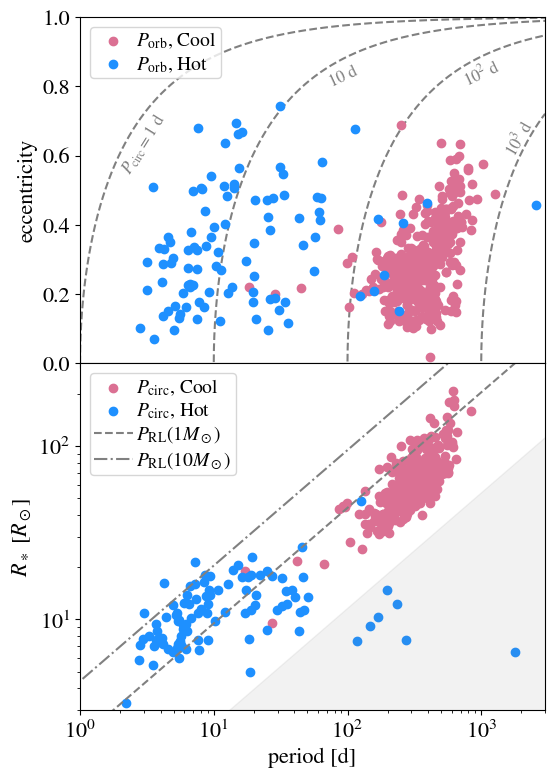

In [10]:
fig,axs = plt.subplots(2,1,figsize=(6,9),sharex=True)

HotC = 'DodgerBlue'
CoolC = 'PaleVioletRed'
selc = hb['sed_teff']<6000.
axs[0].scatter(hb['P'][selc],hb['Ecc'][selc],c=CoolC,label=r'$P_{\rm orb}$, Cool' ,rasterized=True)
axs[0].scatter(hb['P'][selc==False],hb['Ecc'][selc==False],c=HotC,label=r'$P_{\rm orb}$, Hot' ,rasterized=True)
xp = np.logspace(0,4,100000)
for p0 in np.logspace(0,3,4):
    axs[0].plot(xp,np.sqrt(1-(p0/xp)**(2/3.)),ls='--',color='grey',zorder=0 ,rasterized=True)
axs[0].semilogx()
axs[0].set_ylim(0,1)
axs[0].set_xlim(1,3000)

#axs[0].set_xlabel("period [d]")
axs[0].set_ylabel("eccentricity")
axs[0].legend(loc='upper left')
#plt.savefig("figs/PeriodEccentricity.pdf",bbox_inches='tight',dpi=300)
axs[0].annotate(r'$P_{\rm circ}=1$ d',(1.9,0.55),rotation=58,color='grey',fontsize=12)
axs[0].annotate(r'10 d',(70,0.8),rotation=25,color='grey',fontsize=12)
axs[0].annotate(r'$10^2$ d',(700,0.8),rotation=25,color='grey',fontsize=12)
axs[0].annotate(r'$10^3$ d',(1400,0.6),rotation=60,color='grey',fontsize=12)


axs[1].scatter(hb['Pcirc'][selc],hb['sed_radius'][selc],label=r'$P_{\rm circ}$, Cool',color=CoolC,rasterized=True)
axs[1].scatter(hb['Pcirc'][selc==False],hb['sed_radius'][selc==False],label=r'$P_{\rm circ}$, Hot',color=HotC,rasterized=True)
#axs[1].colorbar(label=r"$\log_{10}\left(T_{\rm eff}/K\right)$",extend='both',shrink=0.8)
axs[1].loglog()
xp = np.logspace(0,3)
axs[1].plot(2*np.pi*np.sqrt( (a_RL(0.3)*xp*c.rsun)**3/(c.G*c.msun) )/86400.,xp,'--',color='grey',label=r'$P_{\rm RL} (1M_\odot)$')
axs[1].plot(2*np.pi*np.sqrt( (a_RL(0.3)*xp*c.rsun)**3/(c.G*10*c.msun) )/86400.,xp,'-.',color='grey',label=r'$P_{\rm RL} (10M_\odot)$')



axs[1].set_ylim(3,300)
axs[1].set_ylabel(r'$R_\ast$ [$R_\odot$]')
axs[1].set_xlabel('period [d]')
axs[1].legend(loc='upper left')

axs[1].fill_between(p_cut(xp),xp,y2=1e-2,color='grey',alpha=0.1)


plt.subplots_adjust(hspace=0)
plt.savefig('figs/periods.pdf',bbox_inches='tight',dpi=300)

[-5.  -4.8 -4.6 -4.4 -4.2 -4.  -3.8 -3.6 -3.4 -3.2 -3.  -2.8 -2.6 -2.4
 -2.2 -2.  -1.8 -1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0. ]


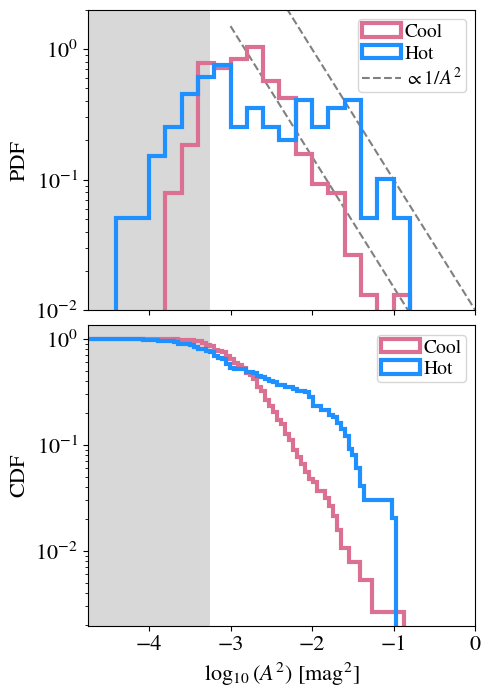

In [11]:
plt.subplots(2,1,sharex=True,figsize=(5,8))


selc = (hb['sed_teff']<6000.) & (hb['tidal_flag']) #& (hb['Model']==1)
selh = (hb['sed_teff']>=6000.) & (hb['tidal_flag']) #& (hb['Model']==1)

plt.subplot(211)
NbinsPDF = 26
binsPDF = np.linspace(-5,0,NbinsPDF)
print(binsPDF)
plt.hist(np.log10(hb['A_hb'][selc]**2),bins=binsPDF,color=CoolC,histtype='step',lw=3,density=True,label='Cool')
plt.hist(np.log10(hb['A_hb'][selc==False]**2),bins=binsPDF,color=HotC,histtype='step',lw=3,density=True,label='Hot')
plt.semilogy()
xp = np.logspace(-3,0)
plt.plot(np.log10(xp),1.5e-3/xp,color='grey',ls='--',zorder=0,label=r'$\propto 1/A^2$')
plt.plot(np.log10(xp),1e-2/xp,color='grey',ls='--',zorder=0)
plt.legend()
plt.xticks(visible=False)
#plt.xlabel(r'$\log_{10}\left(A^2 \right)$ [mag$^2$]')
plt.ylabel('PDF')

plt.axvspan(-3.25, -5, facecolor='grey', alpha=0.3,edgecolor='none')
#plt.xlim(-4.5,0)
plt.ylim(1e-2,2)

plt.subplot(212)
NbinsCDF = NbinsPDF*4
binsCDF = np.linspace(-5,0,NbinsCDF)
plt.hist(np.log10(hb['A_hb'][selc]**2),bins=binsCDF,color=CoolC,histtype='step',lw=3,density=True,label='Cool',cumulative=-1)
plt.hist(np.log10(hb['A_hb'][selc==False]**2),bins=binsCDF,color=HotC,histtype='step',lw=3,density=True,label='Hot',cumulative=-1)

plt.legend()

plt.xlabel(r'$\log_{10}\left(A^{2} \right)$ [mag$^2$]')
plt.ylabel('CDF')

plt.axvspan(-3.25, -5, facecolor='grey', alpha=0.3,edgecolor='none')
plt.xlim(-4.75,0)
#plt.ylim(1.e-5,1.1)
plt.semilogy()


plt.subplots_adjust(hspace=0.05)
plt.savefig("figs/AmpHist.pdf",bbox_inches='tight',dpi=300)

In [12]:
from isochrones.mist import MIST_BasicEvolutionTrack

mist = MIST_BasicEvolutionTrack()
df = mist.model_grid.df

def get_track(df,initial_feh,initial_mass):
    return df.xs((initial_feh,initial_mass))

#get_track(df,-1,1.01)

print("masses=", np.unique( np.round(df.initial_mass,1) ) )


masses= [1.00e-01 2.00e-01 3.00e-01 4.00e-01 5.00e-01 6.00e-01 7.00e-01 8.00e-01
 9.00e-01 1.00e+00 1.10e+00 1.20e+00 1.30e+00 1.40e+00 1.50e+00 1.60e+00
 1.70e+00 1.80e+00 1.90e+00 2.00e+00 2.10e+00 2.20e+00 2.30e+00 2.40e+00
 2.50e+00 2.60e+00 2.70e+00 2.80e+00 3.00e+00 3.20e+00 3.40e+00 3.60e+00
 3.80e+00 4.00e+00 4.20e+00 4.40e+00 4.60e+00 4.80e+00 5.00e+00 5.20e+00
 5.40e+00 5.60e+00 5.80e+00 6.00e+00 6.20e+00 6.40e+00 6.60e+00 6.80e+00
 7.00e+00 7.20e+00 7.40e+00 7.60e+00 7.80e+00 8.00e+00 9.00e+00 1.00e+01
 1.10e+01 1.20e+01 1.30e+01 1.40e+01 1.50e+01 1.60e+01 1.70e+01 1.80e+01
 1.90e+01 2.00e+01 2.20e+01 2.40e+01 2.60e+01 2.80e+01 3.00e+01 3.20e+01
 3.40e+01 3.60e+01 3.80e+01 4.00e+01 4.50e+01 5.00e+01 5.50e+01 6.00e+01
 6.50e+01 7.00e+01 7.50e+01 8.00e+01 8.50e+01 9.00e+01 9.50e+01 1.00e+02
 1.05e+02 1.10e+02 1.15e+02 1.20e+02 1.25e+02 1.30e+02 1.35e+02 1.40e+02
 1.45e+02 1.50e+02 1.75e+02 2.00e+02 2.25e+02 2.50e+02 2.75e+02 3.00e+02]


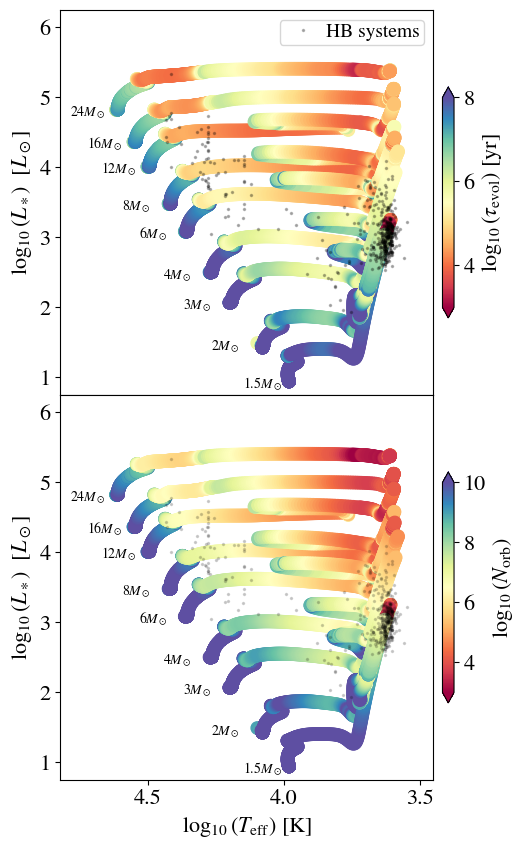

In [13]:
# Combo figure 
fig, axs = plt.subplots(2,1,figsize=(5.8,10),sharex=True)
mycm = 'Spectral_r'

plt.subplot(211)
for i,m in enumerate([24,16,12,8,6,4,3,2,1.5]):
    tr = get_track(df,-1,m)
    sel = (tr['phase']>-1) & (tr['phase']<=4)
    rad = np.array(tr['radius'])
    time = np.array(tr['star_age'])
    radius_timescale = np.abs(rad/np.gradient(rad,time)  )
    plt.scatter(tr['logTeff'][sel],tr['logL'][sel],c=np.log10(radius_timescale)[sel],vmin=3,vmax=8,s=80 ,
               cmap='Spectral',rasterized=True)
    plt.annotate(str(m)+"$M_\odot$",
                 (np.array(tr['logTeff'][sel])[0]+0.17,np.array(tr['logL'][sel])[0]-0.1),fontsize=10 )
    
plt.colorbar(extend='both',shrink=0.6,label=r'$\log_{10}\left(\tau_{\rm evol}\right)$ [yr]',pad=0.02)
plt.xlim(4.82,3.45)
plt.ylim(0.75,6.25)

sel = hb['tidal_flag']
plt.plot(np.log10(hb['sed_teff'])[sel],np.log10(hb['sed_L'])[sel],'.' ,alpha=0.25,color='k',markersize=3,rasterized=True,
        label='HB systems')
plt.legend()
plt.ylabel(r'$\log_{10}\left( L_\ast \right)$  [$L_\odot$]')
#plt.axvline(np.log10(6000),color='grey',zorder=0)

plt.subplot(212)
Ntimes = 10000
mycm = 'Spectral_r'

for i,m in enumerate([24,16,12,8,6,4,3,2,1.5]):
    tr = get_track(df,-1,m)
    sel = (tr['phase']>-1) & (tr['phase']<=4)
    time = np.array(tr['star_age'])
    rad = np.array(tr['radius'])
    mass = np.array(tr['mass'])
    radius_timescale = np.abs(rad/np.gradient(rad,time)  )
    q  = 1/3
    pcirc = 2*np.pi*np.sqrt( (a_RL(q)*rad*c.rsun)**3/(c.G*mass*(1+q)*c.msun) ) / c.yr
    
    plt.scatter(tr['logTeff'][sel],tr['logL'][sel],c=np.log10(radius_timescale/pcirc)[sel],vmin=3,vmax=10,s=80 ,
               cmap='Spectral',rasterized=True)

    
    plt.annotate(str(m)+"$M_\odot$",
                 (np.array(tr['logTeff'][sel])[0]+0.17,np.array(tr['logL'][sel])[0]-0.1),fontsize=10)
    
plt.colorbar(extend='both',shrink=0.6,label=r'$\log_{10}\left(N_{\rm orb}\right)$',pad=0.02)
plt.xlim(4.82,3.45)
plt.ylim(0.75,6.25)


#plt.legend()
plt.xlabel(r'$\log_{10}\left( T_{\rm eff}\right)$ [K]')
plt.ylabel(r'$\log_{10}\left( L_\ast \right)$  [$L_\odot$]')

sel = hb['tidal_flag']
plt.plot(np.log10(hb['sed_teff'])[sel],np.log10(hb['sed_L'])[sel],'.' ,alpha=0.15,color='k',markersize=3,rasterized=True,
        label='HB systems')

#plt.axvline(np.log10(6000),color='grey',zorder=0)
plt.subplots_adjust(hspace=0)

plt.savefig("figs/HRD_tevol.pdf",bbox_inches='tight',dpi=300)

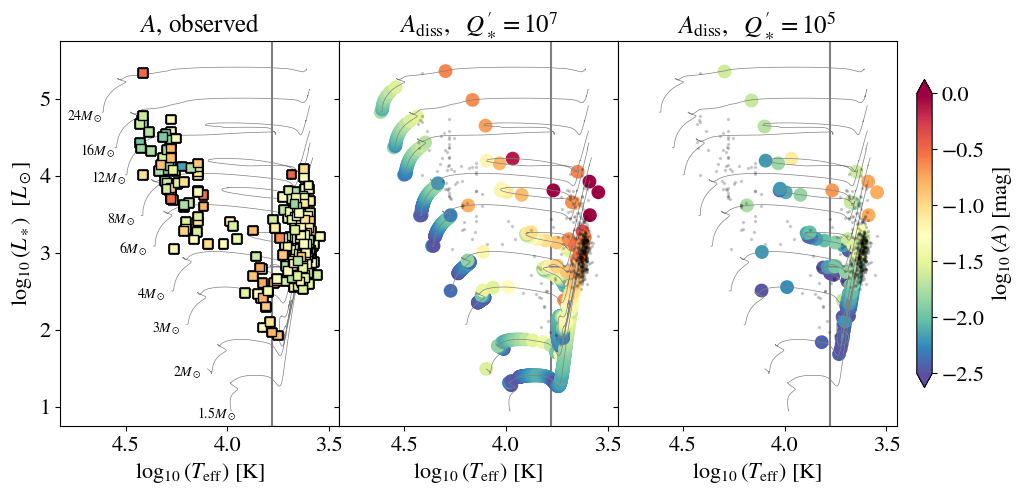

In [14]:
# Adiss vs amplitudes... 
fig, axs = plt.subplots(1,3,figsize=(13,5),sharey=True)
mycm = 'Spectral_r'

for k in range(len(axs)):
    for i,m in enumerate([24,16,12,8,6,4,3,2,1.5]):
        tr = get_track(df,-1,m)
        sel = (tr['phase']>-1) & (tr['phase']<=4)
        time = np.array(tr['star_age'])
        rad = np.array(tr['radius'])
        mass = np.array(tr['mass'])
        radius_timescale = np.abs(rad/np.gradient(rad,time)  )
        q  = 1/3
        pcirc = 2*np.pi*np.sqrt( (a_RL(q)*rad*c.rsun)**3/(c.G*mass*(1+q)*c.msun) ) / c.yr

        # evenly-spaced plotting arrays
        times_plt = np.linspace(time[sel][0],1e10,Ntimes)
        logTeff_plt = np.interp(times_plt,time,tr['logTeff'])
        logL_plt = np.interp(times_plt,time,tr['logL'])
        if k==2:
            Q=1e5
        if k==1:
            Q=10**7
        
        selhb = hb['tidal_flag']
        if k==0:
            axs[k].scatter(np.log10(hb['sed_teff'])[selhb],np.log10(hb['sed_L'])[selhb],c=np.log10(hb['A_hb'][selhb]) ,
            alpha=1,s=40,rasterized=True,zorder=10,cmap=mycm,vmax=0,vmin=-2.5,edgecolor='k',marker='s')
            axs[k].annotate(str(m)+"$M_\odot$",
                     (np.array(tr['logTeff'][sel])[0]+0.17,np.array(tr['logL'][sel])[0]-0.1),fontsize=10)
        else:
            logAcrit_plt = np.interp(times_plt,time,np.log10(np.sqrt(3*q/(2*np.pi*a_RL(q)) *  Q*pcirc/radius_timescale)),left=np.nan,right=np.nan)
            selplt = logAcrit_plt>-2.5
            im = axs[k].scatter(logTeff_plt[selplt],logL_plt[selplt],c=logAcrit_plt[selplt],
                        vmax=0,vmin=-2.5,s=80,
                        cmap=mycm,rasterized=True,label=np.where(i==0,r'$A_{\rm diss}$, 1 Myr intervals',''))
        
        

       
    
        axs[k].plot(tr['logTeff'][sel],tr['logL'][sel],'-',lw=0.5,color='grey')
        


        

plt.subplots_adjust(wspace=0.0)
plt.yticks(visible=False)
for i in range(len(axs)):
    axs[i].set_xlim(4.82,3.45)
    axs[i].set_ylim(.75,5.75)
    axs[i].set_xlabel(r'$\log_{10}\left( T_{\rm eff}\right)$ [K]')
    if i>0:
        axs[i].plot(np.log10(hb['sed_teff'])[selhb],np.log10(hb['sed_L'])[selhb],marker='.',color='k',ls='',
                        alpha=0.15,markersize=3,rasterized=True)
    axs[i].axvline(np.log10(6000),color='grey',zorder=0)

axs[0].set_ylabel(r'$\log_{10}\left( L_\ast \right)$  [$L_\odot$]')
cbar=fig.colorbar(im,label=r'$\log_{10}\left(A\right)$ [mag]',ax=axs[:],shrink=0.8,pad=0.02,extend="both")
cbar.solids.set_edgecolor('face')

axs[0].set_title(r'$A$, observed',fontsize=18)
axs[1].set_title(r"$A_{\rm diss},\ \ Q_\ast' = 10^7$",fontsize=18)
axs[2].set_title(r"$A_{\rm diss},\ \ Q_\ast' = 10^5$",fontsize=18)



plt.savefig("figs/HRD_pop.pdf",bbox_inches='tight',dpi=300)

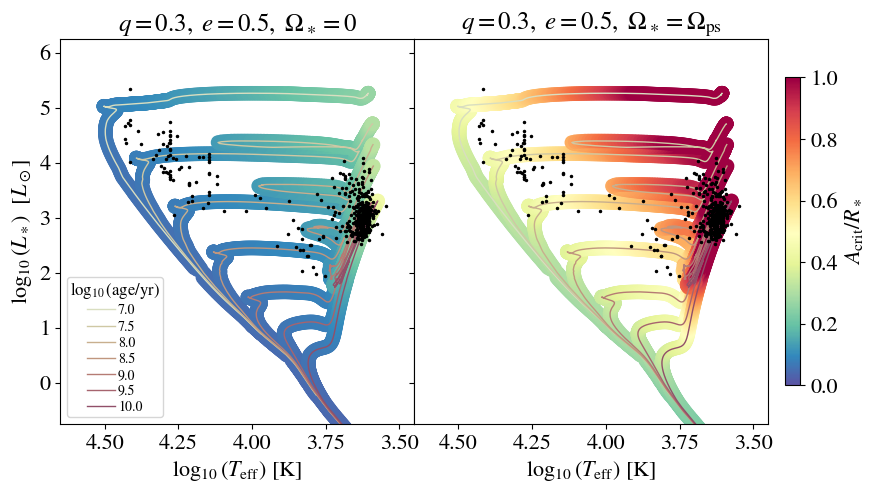

In [15]:
# Wave breaking
mist = MIST_BasicIsochrone()
fig, axs = plt.subplots(1,2,figsize=(11,5),sharey=True)
mycm = 'Spectral_r'


agelist = np.linspace(7,10,7)
pal = sns.cubehelix_palette(len(agelist), start=0,rot=0.6,light=0.85,dark=0.4) 
for i,la in enumerate(agelist):
    iso=mist.isochrone(la,feh)
    sel = (iso['phase']>-1) & (iso['phase']<=4)
    axs[0].plot(iso['logTeff'][sel],iso['logL'][sel],color=pal[i],lw=1,alpha=1,label=la,rasterized=True)
    axs[1].plot(iso['logTeff'][sel],iso['logL'][sel],color=pal[i],lw=1,alpha=1,label=la,rasterized=True)
    iso['cs'] = np.sqrt(c.kB*10**iso['logTeff']/(0.61*c.mp)) 
    iso['Omega_RL'] = Omega_RL(iso['mass']*c.msun,iso['radius']*c.rsun,q=0.3)
    iso['Omega_peri'] = iso['Omega_RL']*omega_peri_factor_rp(ecc=0.5)
    iso['Omega_pseudo'] = iso['Omega_RL']*omega_pseudo_factor_rp(ecc=0.5)
    iso['Omega_tide_pseudo'] = (iso['Omega_peri']-iso['Omega_pseudo'])
    iso['Omega_tide_zero'] = (iso['Omega_peri']-0)
    iso['AoRcrit_pseudo']  = (iso['cs']/iso['Omega_tide_pseudo']) / (iso['radius']*c.rsun)
    iso['AoRcrit_zero']  = (iso['cs']/iso['Omega_tide_zero']) / (iso['radius']*c.rsun)

    axs[0].scatter(iso['logTeff'][sel],iso['logL'][sel],c=iso['AoRcrit_zero'][sel],
                vmin=0,vmax=1,s=90,
                rasterized=True,cmap=mycm)
    im=axs[1].scatter(iso['logTeff'][sel],iso['logL'][sel],c=iso['AoRcrit_pseudo'][sel],
                vmin=0,vmax=1,s=90,
                rasterized=True,cmap=mycm)
    
plt.subplots_adjust(wspace=0.0)
plt.yticks(visible=False)
axs[0].set_xlim(4.65,3.45)
axs[0].set_ylim(-.75,6.25)
axs[1].set_xlim(4.65,3.45)
axs[1].set_ylim(-.75,6.25)
axs[0].set_xlabel(r'$\log_{10}\left( T_{\rm eff}\right)$ [K]')
axs[1].set_xlabel(r'$\log_{10}\left( T_{\rm eff}\right)$ [K]')
axs[0].set_ylabel(r'$\log_{10}\left( L_\ast \right)$  [$L_\odot$]')
cbar=fig.colorbar(im,label=r'$A_{\rm crit}/R_\ast$',ax=axs[:],shrink=0.8,pad=0.02)
cbar.solids.set_edgecolor('face')
axs[1].set_title(r'$q=0.3,\ e=0.5,\ \Omega_\ast=\Omega_{\rm ps}$',fontsize=18)
axs[0].set_title(r'$q=0.3,\ e=0.5,\ \Omega_\ast=0$',fontsize=18)

sel = hb['tidal_flag'] #& (hb['Model']==1)
axs[0].plot(np.log10(hb['sed_teff'])[sel],np.log10(hb['sed_L'])[sel],'.' ,alpha=1,color='k',markersize=3,rasterized=True)
axs[1].plot(np.log10(hb['sed_teff'])[sel],np.log10(hb['sed_L'])[sel],'.' ,alpha=1,color='k',markersize=3,rasterized=True)
axs[0].legend(title='$\log_{10}$(age/yr)',loc='lower left',fontsize=10, title_fontsize=12)

plt.savefig("figs/AcritHRD.pdf",bbox_inches='tight',dpi=300)

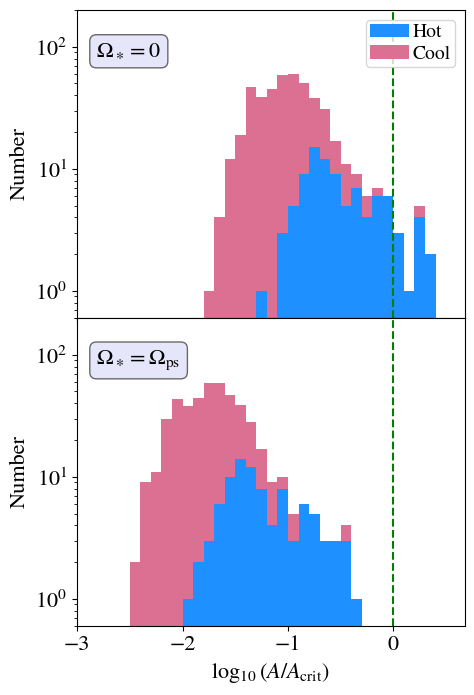

In [16]:
fig,axs = plt.subplots(2,1,figsize=(5,8),sharex=True)

axs[0].hist( [np.log10(hb[selh]['f_crit_zero']),
              np.log10(hb[selc]['f_crit_zero'])],
         histtype='barstacked',label=['Hot','Cool'],bins=np.linspace(-3,0.5,36) ,color=[HotC,CoolC],rasterized=True)
axs[0].legend(loc='upper right')
axs[0].semilogy()
axs[0].axvline(0,ls='--',color='green')
axs[0].set_ylim(0.6,2e2)
axs[0].set_xlim(-3,)
axs[0].set_ylabel("Number")
axs[0].annotate(r'$\Omega_\ast =0$',(0.05,0.85),xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="lavender", ec="dimgrey"))

axs[1].hist( [np.log10(hb[selh]['f_crit_pseudo']),
              np.log10(hb[selc]['f_crit_pseudo'])],
         histtype='barstacked',label=['Hot','Cool'],bins=np.linspace(-3,0.5,36) ,color=[HotC,CoolC],rasterized=True)
axs[1].semilogy()
axs[1].axvline(0,ls='--',color='green')
axs[1].set_ylim(0.6,2e2)
axs[1].set_ylabel("Number")
axs[1].annotate(r'$\Omega_\ast =\Omega_{\rm ps}$',(0.05,0.85),xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="lavender", ec="dimgrey"))


axs[1].set_xlabel(r"$\log_{10}( A / A_{\rm crit} )$")
fig.subplots_adjust(hspace=0)
plt.savefig("figs/AcritHist.pdf",bbox_inches='tight',dpi=300)

In [17]:
hbt = hb[hb['tidal_flag']].copy()
hbt.sort('f_crit_pseudo')
hbt.reverse()

print( hbt[0:15] )

       ID        Type      RA         Decl      I    ... A_adjust  A_hb    f_crit_zero        f_crit_pseudo   
---------------- ---- ----------- ----------- ------ ... -------- ----- ------------------ -------------------
OGLE-LMC-HB-0254   MS 05:26:24.45 -68:47:05.0 13.473 ...      nan 0.321  2.466489715726702 0.46197674294201185
OGLE-LMC-HB-0292   MS 05:30:18.89 -70:26:24.5 15.908 ...      nan 0.147 1.9829968802391895 0.39666749573035204
OGLE-LMC-HB-0185   MS 05:17:44.82 -69:37:39.6 16.482 ...      nan 0.185 2.0332064435960193 0.37859220983151326
OGLE-LMC-HB-0337   MS 05:35:06.34 -70:16:26.5 16.465 ...      nan 0.196 1.8390325933842515 0.35569227299029954
OGLE-SMC-HB-0001   MS 00:22:01.64 -74:32:32.7 16.498 ...      nan 0.313 1.6367209279562807 0.32256402877804374
OGLE-SMC-HB-0006   MS 00:45:25.85 -72:52:45.2 17.094 ...      nan 0.134 1.6509874372932074 0.29941751247834975
OGLE-SMC-HB-0004   MS 00:44:17.74 -73:03:42.4 16.091 ...      nan 0.123 1.4931455925542392 0.28611839361216496
O

In [18]:
hbt[0:3]

ID,Type,RA,Decl,I,V,V_I,P,T0,A,Ecc,Incl,Peri,Model,loc,sed_dist,sed_av,sed_av_err,sed_radius,sed_radius_err,sed_teff,sed_teff_err,sed_logg,sed_logg_err,sed_feh,sed_irslope,sed_chi2oN,Av_median,Av_minus_two_sigma,Av_plus_two_sigma,sed_L,Pcirc,sed_cs,Omega_orb,Omega_peri,Omega_pseudo,AoRcrit_zero,Omega_tide_pseudo,AoRcrit_pseudo,sed_L_err,tidal_flag,A_adjust,A_hb,f_crit_zero,f_crit_pseudo
str16,str2,str11,str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str3,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64
OGLE-LMC-HB-0254,MS,05:26:24.45,-68:47:05.0,13.473,13.772,0.299,32.82939,9031.003,0.321,0.5473,42.51,130.64,1,LMC,49970.0,1.0510417946334403,0.08887537941524247,22.907000901723276,0.9565704724132448,26000.00005351797,1713.5731055296892,1.734775466592219,371974.12638619135,-0.7,0.08553329211432227,1.646898662354261,0.43425,0.0,1.09125,217695.09613902876,19.24599387592406,1875710.995938926,2.2151508805503365e-06,9.046380146404204e-06,7.35198133792599e-06,0.13014447129183498,1.6943988084782146e-06,0.6948401730263996,31443.45993637775,True,nan,0.321,2.466489715726702,0.46197674294201185
OGLE-LMC-HB-0292,MS,05:30:18.89,-70:26:24.5,15.908,15.948,0.04,3.1858559,9001.6509,0.147,0.292,89.5,147.4,0,LMC,49970.0,0.0092525471367484,0.11483194841061152,7.140723944700849,0.5087288298895243,18999.999956744727,2930.0109154095103,2.1146029440019967,367303.04898811685,-0.7,0.057774529594652034,1.3378885871556592,0.18675,0.0,0.42075,6032.782561965144,2.7872106018865113,1603452.3184445493,2.2826535301370787e-05,4.3553330202382426e-05,3.484116802287749e-05,0.07413022252575042,8.712162179504934e-06,0.37058746073796817,1957.4076236398525,True,nan,0.147,1.9829968802391895,0.39666749573035204
OGLE-LMC-HB-0185,MS,05:17:44.82,-69:37:39.6,16.482,16.925,0.443,31.19359,9004.584,0.185,0.5672,64.5,73.6,0,LMC,49970.0,0.14770304593188086,0.9545765730269905,14.733694115469238,1.8291493826039256,6749.999933963397,1815.5137933293056,2.9940759765987934,1.8898090606240883,-0.7,0.00903275314660411,5.943684155701839,0.1305,0.0,0.4275,409.1260733405621,17.425404659216543,955721.0118687345,2.3313139708007444e-06,1.0250194341903256e-05,8.341561925688723e-06,0.09098928472447726,1.9086324162145328e-06,0.48865242124852876,231.5067437195071,True,nan,0.185,2.0332064435960193,0.37859220983151326


In [19]:
hbtm = hb[hb['tidal_flag'] & (hb['Model']==1)].copy()
hbtm.sort('f_crit_pseudo')
hbtm.reverse()

print( hbtm[0:15] )

       ID        Type      RA         Decl      I    ... A_adjust  A_hb     f_crit_zero        f_crit_pseudo   
---------------- ---- ----------- ----------- ------ ... -------- ----- ------------------- -------------------
OGLE-LMC-HB-0254   MS 05:26:24.45 -68:47:05.0 13.473 ...      nan 0.321   2.466489715726702 0.46197674294201185
OGLE-SMC-HB-0006   MS 00:45:25.85 -72:52:45.2 17.094 ...      nan 0.134  1.6509874372932074 0.29941751247834975
OGLE-LMC-HB-0404   MS 05:46:01.61 -67:35:54.6 14.291 ...      nan 0.132  1.1077098915761636  0.2216562106553655
OGLE-LMC-HB-0329   MS 05:34:07.84 -69:05:11.7 17.857 ...      nan 0.097  0.8316936641003091  0.1655627001434995
OGLE-SMC-HB-0005   MS 00:44:46.60 -73:17:09.7 17.593 ...      nan 0.124   0.812026018752559 0.15852356696369005
OGLE-LMC-HB-0266   MS 05:27:29.73 -70:44:15.6   17.2 ...      nan 0.074  0.7479833658883644 0.13185121091613927
OGLE-LMC-HB-0365   MS 05:38:32.64 -69:03:56.0  16.61 ...      nan 0.056   0.628335400030005 0.1135796017

couldnt find: OGLE-LMC-HB-0185
couldnt find: OGLE-LMC-HB-0350


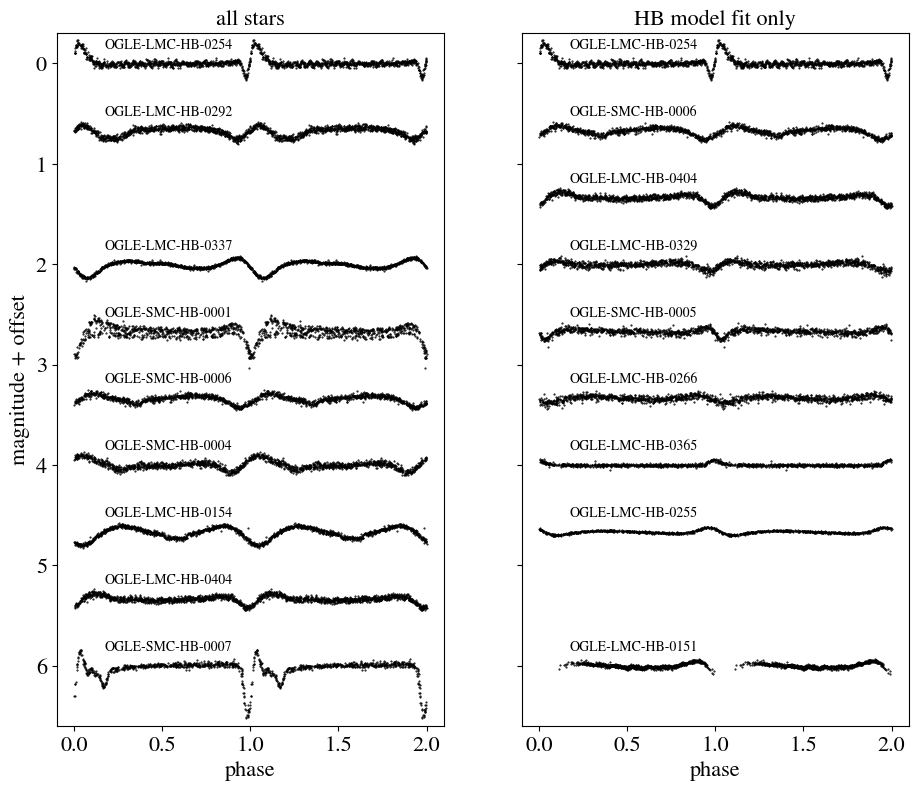

In [20]:
def read_phase_phot(ID):
    fn = "ogle_lc_data/" + ID + ".dat"
    phot = Table.read(fn,format='ascii',names=['mjd','mag','mag_err'])
    
    sel = hb['ID']==ID
    t0 = hb[sel]['T0'][0]
    per = hb[sel]['P'][0]
    phot['phase'] = ((phot['mjd']-t0)%per )/per
    phot['mag_zeroed']  = phot['mag']-np.median(phot['mag'])  
    return phot 


#phot = read_phase_phot('OGLE-LMC-HB-0254')
#plt.plot(phot['phase'],phot['mag'],'k.')
#plt.plot(phot['phase']+1,phot['mag'],'k.')
#phot

plt.subplots(1,2, sharey=True, figsize=(11,9))
ms = 1
off_fac = 1.5

plt.subplot(121)
for i in range(10):
    try:
        phot = read_phase_phot(hbt['ID'][i])
        offset_mag = i/off_fac
        plt.plot(phot['phase'],phot['mag_zeroed']+offset_mag,'k.',markersize=ms,rasterized=True)
        plt.plot(phot['phase']+1,phot['mag_zeroed']+offset_mag,'k.',markersize=ms,rasterized=True)
        plt.annotate(hbt['ID'][i],(0.17,offset_mag - 0.15),fontsize=10 ) 
    except:
        print('couldnt find:',hbt['ID'][i])
        


plt.ylim(6.6,-0.3)
plt.xlabel('phase')
plt.ylabel('magnitude + offset')
plt.title('all stars',fontsize=16)

plt.subplot(122)
for i in range(10):
    try:
        phot = read_phase_phot(hbtm['ID'][i])
        offset_mag = i/off_fac
        plt.plot(phot['phase'],phot['mag_zeroed']+offset_mag,'k.',markersize=ms,rasterized=True)
        plt.plot(phot['phase']+1,phot['mag_zeroed']+offset_mag,'k.',markersize=ms,rasterized=True)
        plt.annotate(hbtm['ID'][i],(0.17,offset_mag - 0.15),fontsize=10 ) 
    except:
        print('couldnt find:',hbtm['ID'][i])
    
plt.ylim(6.6,-0.3)

plt.title('HB model fit only',fontsize=16)
plt.xlabel('phase')
plt.savefig('figs/lc_gallery.pdf',dpi=300, bbox_inches='tight')